<a name="top"></a>
<br/>
# Using `medGAN` to boost the prediction score with data augmentation on the MIMIC-III dataset of shape (1000, 100) with binary values

Author: [Sylvain Combettes](https://github.com/sylvaincom). <br/>
Last update: Sep 11, 2019. Creation: Aug 12, 2019. <br/>
My own `medGAN` repository: [medgan-tips](https://github.com/sylvaincom/medgan-tips) (based on Edward Choi's work). <br/>
Edward Choi's original repository: [medgan](https://github.com/mp2893/medgan).

Before reading this notebook, make sure that you have read my [medGAN repository](https://github.com/sylvaincom/medgan-tips)'s table of contents.

### Using `medGAN` for data augmentation

One application of `medGAN` is to use the fictitious generated dataset to help enrich the original real-life dataset (for data augmentation) to try to boost the prediction score. Here, we act as if we were in a real-life case and all that we have at our disposal is a real-life dataset (called `real`) of shape (1 000, 100). We want to use `medGAN` to generate a new fictitious realistic dataset called `fict` of 1 000 fictitious realistic samples (with 100 features as well). By adding (meaning concatenating) `fict` to `real`, we get a new augmented dataset (called `aug`) that has 2 000 samples (patients) (and also 100 features). We hope that building our model on `aug` helps our prediction algorithms make better predictions than building our model on `real`.
Here is a recap:

| | `real` dataset | `fict` dataset | `aug` dataset |
|---|---|---|---|
| number of samples | 1 000 | 1 000 | 2 000 |
| number of features | 100 | 100 | 100 |

_How do we compute the prediction score of a dataset?_ Out of the 100 features of our dataset, we select one that we call `target`. We are going to try to predict the `target` feature using the remaining 99 features. The scores are computed with cross-validation (thus we do not divide our dataset into train / valid / test). We choose our hyper-parameters with randomized search (using a random seed for reproducibility). Check [5) Can training on the augmented dataset help improve the prediction score with a real-life test set?](#aug2) for a different approach.

---
### Table of contents

- [1) Loading the data](#load)
- [2) Predicting the column `target` with (only) the original real-life dataset](#input)
- [3) Predicting the column `target` with (only) the fictitious generated dataset](#output)
- [4) Predicting the column `target` with data augmentation](#aug)
- [5) Can training on the augmented dataset help improve the prediction score with a real-life test set?](#aug2)

---
### Imports

In [1]:
import numpy as np
import pandas as pd
import pickle
import matplotlib.pyplot as plt
from time import process_time
import datetime
import random

from sklearn import datasets, model_selection, linear_model, neighbors, neural_network, naive_bayes
from sklearn.linear_model import LinearRegression, LogisticRegression, Ridge, Lasso
from sklearn.ensemble import RandomForestClassifier
from sklearn.model_selection import GridSearchCV, RandomizedSearchCV
from sklearn.svm import SVC

---
<a name="load"></a>
# 1) Loading the data

## 1.1) Loading the real-life original dataset

We refer to the real-life original dataset as `df_real`.

In [2]:
real_data_array = pickle.load(open('training-data-small.matrix', 'rb')) # real-life dataset
df_real = pd.DataFrame(real_data_array)
#df_real = df_real.sample(1000, random_state=1)
df_real = df_real.sample(100, axis=1, random_state=1)

print('The shape of the real-life original dataset is :', df_real.shape)
df_real.head(5)

The shape of the real-life original dataset is : (100, 100)


,80,84,33,81,93,17,36,82,69,65,...,1,16,64,79,5,75,9,72,12,37
0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0
1,0.0,0.0,0.0,0.0,0.0,0.0,1.0,0.0,0.0,0.0,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,1.0,0.0
2,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0
3,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0
4,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0


## 1.2) Loading the fictitious generated dataset

We refer to the fictitious generated dataset as `df_fict`.

In [3]:
fict = np.load('gen-samples.npy')
df_fict = pd.DataFrame(fict, columns = df_real.columns).round(0)
print('The shape of the fictitious generated dataset is :', df_fict.shape)
df_fict.head(5)

The shape of the fictitious generated dataset is : (10000, 100)


,80,84,33,81,93,17,36,82,69,65,...,1,16,64,79,5,75,9,72,12,37
0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,...,0.0,1.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0
1,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,...,0.0,1.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0
2,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,...,0.0,1.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0
3,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0
4,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0


## 1.3) Choosing the feature we are going to try to predict: `target`

Which feature are we going to try to predict? We want to predict the feature with the highest variance. Indeed, a feature with a low variance, for example, with only 1s, is very easy to predict for new unseen samples because we put 1s. Thus, we want `target` to have a proportion of 1s that is the closest to 50%.

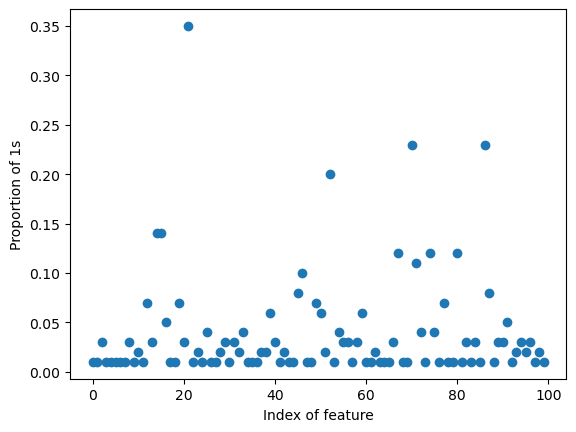

In [4]:
plt.plot(df_real.sum()/df_real.shape[0], 'o')
plt.xlabel('Index of feature')
plt.ylabel('Proportion of 1s')
plt.show()

In [5]:
target = df_real.sum().idxmax(axis=0)
print('The feature index of target is :', target)
print('Approx. proportion of 1s of target :',
      round(df_real[target].sum()/df_real.shape[0], 4))

The feature index of target is : 21
Approx. proportion of 1s of target : 0.35


---
<a name="input"></a>
# 2) Predicting the column `target` with (only) the original real-life dataset

## 2.1) Preparing the data

In [6]:
df = df_real
X_dataset = df.loc[:, df.columns != target].values
y_dataset = np.ravel(df.loc[:, df.columns == target].values)
print(X_dataset.shape, y_dataset.shape)

(100, 99) (100,)


## 2.2) Benchmarking some models according to their score

We define our benchmarking function:

In [7]:
def score_and_time(model, X_dataset, y_dataset, cv):
    """
    When there are no hyper-parameters.
    This function returns a list with the scores and processing times of model.
    The scores are calculated with cross_val_score (with K-Fold equal to cv).
    """
    t_start = process_time()
    scores = model_selection.cross_val_score(model, X_dataset, y_dataset, cv=cv)
    t_stop = process_time()
    part_l = [round(scores.mean(), 3), round(scores.std()*2, 3), str(datetime.timedelta(seconds=t_stop-t_start))]
    return part_l

#def score_and_time_hyp(model, parameters, X_dataset, y_dataset, cv):
    """
    When there are hyper-parameters.
    This function returns a list with the scores and processing times of model.
    The scores are calculated with RandomizedSearchCV (with K-Fold equal to cv) (we use a random seed).
    """
    #t_start = process_time()
    #clf_grid = RandomizedSearchCV(model, parameters, cv=cv, random_state=1, n_jobs=-1)  
    #clf_grid.fit(X_dataset, y_dataset)
    #scores = clf_grid.best_score_ # mean cross-validated score of the best_estimator
    #t_stop = process_time()
    #part_l = [round(scores.mean(), 3), '-', str(datetime.timedelta(seconds=t_stop-t_start))]
    #return part_l

#Changing a bit of code because the line n_jobs=-1 tells RandomizedSearchCV to use all 
#available CPU cores for parallel processing.
#n_jobs=1 limits processing to a single thread.
#n_iter=min(10, total_combinations) ensures you don’t try more combinations than exist (which avoids another ValueError crash).
def score_and_time_hyp(model, parameters, X_dataset, y_dataset, cv):
    """
    When there are hyper-parameters.
    This function returns a list with the scores and processing times of model.
    The scores are calculated with RandomizedSearchCV (with K-Fold equal to cv) (we use a random seed).
    """
    t_start = process_time()

    total_combinations = 1
    for key in parameters:
        total_combinations *= len(parameters[key])

    n_iter = min(10, total_combinations)  # Safe cap to avoid crash

    clf_grid = RandomizedSearchCV(model, parameters, cv=cv, n_iter=n_iter, random_state=1, n_jobs=1)
    clf_grid.fit(X_dataset, y_dataset)
    scores = clf_grid.best_score_
    
    t_stop = process_time()
    part_l = [round(scores, 3), '-', str(datetime.timedelta(seconds=t_stop - t_start))]
    return part_l



def ml_benchmark(X_dataset, y_dataset, cv):
    print('The shape of X_dataset is :', X_dataset.shape)
    print('The shape of y_dataset is :', y_dataset.shape)

    rows_name = ["Logistic Regression", "Nearest Neighbors", "Naive Bayes",
                 "Perceptron", "SVM", "Random Forest", "Multi-Layer Perceptron"]

    columns_name = ['Approx. mean of scores', 'Approx. variance of scores', 'Processing time']
    l = []

    # Logistic Regression
    model = linear_model.LogisticRegression()
    parameters = {
        'solver': ['lbfgs', 'sag', 'saga'],
        'multi_class': ['multinomial'],
        'warm_start': [True, False],
        'C': [0.01, 0.1, 1, 10]
    }
    l.append(score_and_time_hyp(model, parameters, X_dataset, y_dataset, cv))

    # Nearest Neighbors
    model = neighbors.KNeighborsClassifier()
    parameters = {
        'n_neighbors': [3, 5, 7, 9],
        'algorithm': ['auto', 'kd_tree']
    }
    l.append(score_and_time_hyp(model, parameters, X_dataset, y_dataset, cv))

    # Naive Bayes
    model = naive_bayes.GaussianNB()
    l.append(score_and_time(model, X_dataset, y_dataset, cv))

    # Perceptron
    model = linear_model.Perceptron()
    l.append(score_and_time(model, X_dataset, y_dataset, cv))

    # SVM
    model = SVC(kernel='rbf', class_weight='balanced')
    parameters = {
        'C': [0.01, 0.1, 1, 10],
        'gamma': [0.001, 0.01, 0.1]
    }
    l.append(score_and_time_hyp(model, parameters, X_dataset, y_dataset, cv))

    # Random Forest
    model = RandomForestClassifier()
    parameters = {
        'n_estimators': [100, 200],
        'max_depth': [10, 20, 50],
        'bootstrap': [True],
        'max_features': ['sqrt'],
        'min_samples_split': [2, 5],
        'criterion': ['gini'],
        'random_state': [0]
    }
    l.append(score_and_time_hyp(model, parameters, X_dataset, y_dataset, cv))

    # Multi-Layer Perceptron
    model = neural_network.MLPClassifier()
    parameters = {
        'solver': ['adam'],                             # Faster than lbfgs, good for medium data
        'max_iter': [500, 1000],                        # Enough for convergence
        'alpha': [0.0001, 0.001],                       # Regularization
        'hidden_layer_sizes': [(10,), (20,), (10, 5)],  # Mix of shallow and moderately deep
        'activation': ['relu', 'tanh']                  # Cover both major activations
    }
    l.append(score_and_time_hyp(model, parameters, X_dataset, y_dataset, cv))

    out = pd.DataFrame(l, index=rows_name, columns=columns_name)
    return out



We apply our benchmarking function:

In [10]:
real_benchmark = ml_benchmark(X_dataset, y_dataset, 5)
real_benchmark.to_csv('real_benchmark.csv', sep=';') # saving the results

real_benchmark_sorted = real_benchmark.sort_values(by=['Approx. mean of scores'], ascending=False)
real_benchmark_sorted

The shape of X_dataset is : (100, 99)
The shape of y_dataset is : (100,)


C:\Anaconda\lib\site-packages\sklearn\linear_model\_logistic.py:1237: FutureWarning: 'multi_class' was deprecated in version 1.5 and will be removed in 1.7. From then on, binary problems will be fit as proper binary  logistic regression models (as if multi_class='ovr' were set). Leave it to its default value to avoid this warning.
  warnings.warn(
C:\Anaconda\lib\site-packages\sklearn\linear_model\_logistic.py:1237: FutureWarning: 'multi_class' was deprecated in version 1.5 and will be removed in 1.7. From then on, binary problems will be fit as proper binary  logistic regression models (as if multi_class='ovr' were set). Leave it to its default value to avoid this warning.
  warnings.warn(
C:\Anaconda\lib\site-packages\sklearn\linear_model\_logistic.py:1237: FutureWarning: 'multi_class' was deprecated in version 1.5 and will be removed in 1.7. From then on, binary problems will be fit as proper binary  logistic regression models (as if multi_class='ovr' were set). Leave it to its defa

C:\Anaconda\lib\site-packages\sklearn\linear_model\_logistic.py:1237: FutureWarning: 'multi_class' was deprecated in version 1.5 and will be removed in 1.7. From then on, binary problems will be fit as proper binary  logistic regression models (as if multi_class='ovr' were set). Leave it to its default value to avoid this warning.
  warnings.warn(
C:\Anaconda\lib\site-packages\sklearn\linear_model\_logistic.py:1237: FutureWarning: 'multi_class' was deprecated in version 1.5 and will be removed in 1.7. From then on, binary problems will be fit as proper binary  logistic regression models (as if multi_class='ovr' were set). Leave it to its default value to avoid this warning.
  warnings.warn(
C:\Anaconda\lib\site-packages\sklearn\linear_model\_logistic.py:1237: FutureWarning: 'multi_class' was deprecated in version 1.5 and will be removed in 1.7. From then on, binary problems will be fit as proper binary  logistic regression models (as if multi_class='ovr' were set). Leave it to its defa

C:\Anaconda\lib\site-packages\sklearn\neural_network\_multilayer_perceptron.py:691: ConvergenceWarning: Stochastic Optimizer: Maximum iterations (500) reached and the optimization hasn't converged yet.
  warnings.warn(
C:\Anaconda\lib\site-packages\sklearn\neural_network\_multilayer_perceptron.py:691: ConvergenceWarning: Stochastic Optimizer: Maximum iterations (500) reached and the optimization hasn't converged yet.
  warnings.warn(
C:\Anaconda\lib\site-packages\sklearn\neural_network\_multilayer_perceptron.py:691: ConvergenceWarning: Stochastic Optimizer: Maximum iterations (500) reached and the optimization hasn't converged yet.
  warnings.warn(
C:\Anaconda\lib\site-packages\sklearn\neural_network\_multilayer_perceptron.py:691: ConvergenceWarning: Stochastic Optimizer: Maximum iterations (500) reached and the optimization hasn't converged yet.
  warnings.warn(
C:\Anaconda\lib\site-packages\sklearn\neural_network\_multilayer_perceptron.py:691: ConvergenceWarning: Stochastic Optimizer

,Approx. mean of scores,Approx. variance of scores,Processing time
Nearest Neighbors,0.69,-,0:00:00.875000
Random Forest,0.69,-,0:00:09.234375
Logistic Regression,0.66,-,0:00:00.328125
SVM,0.65,-,0:00:00.203125
Multi-Layer Perceptron,0.64,-,0:00:10.859375
Perceptron,0.57,0.258,0:00:00.015625
Naive Bayes,0.52,0.28,0:00:00


---
<a name="output"></a>
# 3) Predicting the column `target` with (only) the fictitious generated dataset

## 3.1) Preparing the data

In [11]:
df = df_fict
X_dataset = df.loc[:, df.columns != target].values
y_dataset = np.ravel(df.loc[:, df.columns == target].values)
print(X_dataset.shape, y_dataset.shape)

(10000, 99) (10000,)


## 3.2) Benchmarking some models according to their score

In [12]:
fict_benchmark = ml_benchmark(X_dataset, y_dataset, 5)
fict_benchmark.to_csv('fict_benchmark.csv', sep=';') # saving the results

fict_benchmark_sorted = fict_benchmark.sort_values(by=['Approx. mean of scores'], ascending=False)
fict_benchmark_sorted

The shape of X_dataset is : (10000, 99)
The shape of y_dataset is : (10000,)


ValueError: This solver needs samples of at least 2 classes in the data, but the data contains only one class: 0.0

---
<a name="aug"></a>
# 4) Predicting the column `target` with data augmentation

## 4.1) Preparing the data

We concatenate the real-life dataset `df_real` and the fictitious generated dataset `df_fict` into an augmented dataset `df_aug`.

In [13]:
df_aug = df_real.append(df_fict)

X_dataset = df_aug.loc[:, df_aug.columns != target].values
y_dataset = np.ravel(df_aug.loc[:, df_aug.columns == target].values)
print(X_dataset.shape, y_dataset.shape)

(10100, 99) (10100,)


## 4.2) Benchmarking some models according to their score

In [ ]:
aug_benchmark = ml_benchmark(X_dataset, y_dataset, 5)
aug_benchmark.to_csv('aug_benchmark.csv', sep=';') # saving the results

aug_benchmark_sorted = aug_benchmark.sort_values(by=['Approx. mean of scores'], ascending=False)
aug_benchmark_sorted

The shape of X_dataset is : (10100, 99)
The shape of y_dataset is : (10100,)


C:\Anaconda\envs\MedGAN1\lib\site-packages\sklearn\linear_model\sag.py:326: ConvergenceWarning: The max_iter was reached which means the coef_ did not converge
  "the coef_ did not converge", ConvergenceWarning)
C:\Anaconda\envs\MedGAN1\lib\site-packages\sklearn\linear_model\sag.py:326: ConvergenceWarning: The max_iter was reached which means the coef_ did not converge
  "the coef_ did not converge", ConvergenceWarning)
C:\Anaconda\envs\MedGAN1\lib\site-packages\sklearn\linear_model\sag.py:326: ConvergenceWarning: The max_iter was reached which means the coef_ did not converge
  "the coef_ did not converge", ConvergenceWarning)
C:\Anaconda\envs\MedGAN1\lib\site-packages\sklearn\linear_model\sag.py:326: ConvergenceWarning: The max_iter was reached which means the coef_ did not converge
  "the coef_ did not converge", ConvergenceWarning)
C:\Anaconda\envs\MedGAN1\lib\site-packages\sklearn\linear_model\sag.py:326: ConvergenceWarning: The max_iter was reached which means the coef_ did not c

## 4.3) Comparison: can data augmentation boost the score?

In [ ]:
xaxis = real_benchmark['Approx. mean of scores'].values
yaxis = aug_benchmark['Approx. mean of scores'].values

start = min(np.min(xaxis), np.min(yaxis))
stop = max(np.max(xaxis), np.max(yaxis))
p = len(xaxis)
X = np.linspace(start, stop, num=p+1)

plt.plot(xaxis, yaxis, 'ok', X, X, '-g');

plt.legend(['Approx. mean of scores', 'Equal approx. mean of scores'])
plt.title('Boosting the prediction score with data augmentation')
plt.xlabel('For the real dataset')
plt.ylabel('For the augmented dataset')
plt.savefig('comparison_small.png', dpi=120) # to save the figure
plt.show()

We can observe graphically the increase in the prediction score. The values of the $x$-axis and the $y$-axis are ordered.
The diagonal green line indicates where the real and the augmented data show identical performance for a given machine learning model. Based on the graph, we can say that `medGAN` can perform data augmentation and boost the prediction score. Indeed, the dots are mostly on top of the green line.

By what percentage did we increase of prediction score of our best machine learning models with data augmentation?

In [ ]:
score_real = real_benchmark['Approx. mean of scores'].values
score_aug = aug_benchmark['Approx. mean of scores'].values
score_inc = (score_aug-score_real)/score_real*100
df_score_inc = round(pd.DataFrame(score_inc, index=real_benchmark.index.values, columns=['Prediction score increase (%)']), 2)
df_score_inc.to_csv('scores_increase_small.csv', sep=';')
df_score_inc

In [ ]:
best_ml = real_benchmark_sorted.index.values[0]
print('The best machine learning model on the original real-life dataset is :', best_ml)
best_ml_aug = aug_benchmark_sorted.index.values[0]
print('The best machine learning model on the augmented dataset is :', best_ml_aug)

percentage = df_score_inc.loc[[best_ml], ['Prediction score increase (%)']].values[0][0]
print('We increased the prediction score of', best_ml, 'by approx.', percentage, '%')

With data augmentation, we have an increase in score: up to almost 5%!

However, **we should not try to measure the score increase of data augmentation with a cross-validation because `target` would contain fictitious generated values**.

In the previous table and graph, we showed that data augmentation can boost the prediction score. However, we kind of cheated because half of the values of `target` in `aug` are fictitious generated values from `fict`. Thus, we try to use fictitious features to predict a `target` feature that is also fictitious. Hence, the score increase is natural and not due to data augmentation itself.

We now try to avoid this problem by dividing our datasets into train/test and choosing our hyper-parameters with a randomzied search (using a random seed for reproducibility). We take take `real` (or `aug`) for the training set and we take only real-life values for the test set. The real-life values for the test set will come from values from the full MIMIC-III dataset. We recall that we only took 1 000 samples out of the 46 520 for `real`.

---
<a name="aug2"></a>
# 5) Can training on the augmented dataset help improve the prediction score with a real-life test set?


## 5.1) Without data augmentation

### 5.1.a) Loading the data

#### Training set

We now split our `real` dataset of shape (1 000, 100) into `X_train` and `y_train` (that is actually `target`). We try to use `X_train` and `y_train` to build a model that can predict $y$ for an unseen $X$.

In [ ]:
X_train = df_real.loc[:, df_real.columns != target].values
y_train = np.ravel(df_real.loc[:, df_real.columns == target].values)
print(X_train.shape, y_train.shape)

#### Test set

For the `test` set, we randomly select 250 samples (and the same 100 features as `real`) from the complete MIMIC-III dataset of shape (46 520, 1 071) that are not already samples in `real`.

In [ ]:
# We import the full real-life test:
real_data_array_full = pickle.load(open('training-data.matrix', 'rb'))
df_real_full = pd.DataFrame(real_data_array_full)

# We select that are not already in df_real:
df_test = df_real_full[~df_real_full.isin(df_real)].dropna().sample(250, random_state=56)

# We select the same rows as df_real:
df_test = df_test.sample(100, axis=1, random_state=1)

# We only select some rows for the real-life dataset to be the test set
n,p = df_aug.shape
print('The shape of the augmented training set is', (n,p))
print('The shape of our test set is', df_test.shape)

We split our `test` dataset of shape (250, 100) into `X_test` and `{y_test` (that is actually `target`):

In [ ]:
X_test = df_test.loc[:, df_test.columns != target].values
y_test = np.ravel(df_test.loc[:, df_test.columns == target].values)
print(X_test.shape, y_test.shape)

### 5.1.b) Benchmarking some models according to their score

Let `model` be a machine learning model of our benchmark such as the perceptron. We fit the model with `model.fit(X_train, y_train)` then compute the score with `model.score(X_test, y_test)`.

We define our benchmarking function:

In [ ]:
def score(model, X_train, y_train, X_test, y_test):
    t_start = process_time()
    model.fit(X_train, y_train)
    score = model.score(X_test, y_test)
    t_stop = process_time()
    return [round(score, 3), str(datetime.timedelta(seconds=t_stop-t_start))]

def ml_benchmark(X_train, y_train, X_test, y_test, cv):
    """
    This function returns a pandas dataframe with the scores and processing times of some classic
    machine learning models.
    If there are hyper-parameters, there are computed with RandomizedSearchCV.
    """
    
    print('The shape of X_train is :', X_train.shape)
    print('The shape of y_train is :', y_train.shape)
     
    rows_name = ["Logistic Regression", "Nearest Neighbors", "Naive Bayes",
                  "Perceptron", "SVM", "Random Forest", "Multi-Layer Perceptron"]
    
    columns_name = ['Approx. score', 'Processing time']
    
    l = []
    
    model = linear_model.LogisticRegression()
    parameters = {'solver': ['lbfgs','liblinear','sag','saga'], 'multi_class': ['auto'],
                 'warm_start': [True, False], 'C': [0.01,0.1,1,10,100]}
    clf_grid = RandomizedSearchCV(model, parameters, cv=cv, random_state=1, n_jobs=-1)  
    clf_grid.fit(X_train, y_train)
    final_model = linear_model.LogisticRegression(**clf_grid.best_params_)
    l.append(score(final_model, X_train, y_train, X_test, y_test))
    
    model = neighbors.KNeighborsClassifier()
    parameters = {'n_neighbors': [1,2,3,5,8,10,20], 'algorithm': ['ball_tree', 'kd_tree', 'brute']}
    clf_grid = RandomizedSearchCV(model, parameters, cv=cv, random_state=1, n_jobs=-1)  
    clf_grid.fit(X_train, y_train)
    final_model = neighbors.KNeighborsClassifier(**clf_grid.best_params_)
    l.append(score(final_model, X_train, y_train, X_test, y_test))
    
    model = naive_bayes.GaussianNB()
    l.append(score(model, X_train, y_train, X_test, y_test))
    
    model = linear_model.Perceptron()
    l.append(score(model, X_train, y_train, X_test, y_test))
    
    model = SVC(kernel='rbf', class_weight='balanced')
    parameters = {'C': [0.0001, 0.001, 0.005, 0.01, 0.1, 0, 10, 1e2, 1e3, 1e4, 1e5],
                  'gamma': [0.0001, 0.0005, 0.001, 0.005, 0.01, 0.1]}
    clf_grid = RandomizedSearchCV(model, parameters, cv=cv, random_state=1, n_jobs=-1)  
    clf_grid.fit(X_train, y_train)
    final_model = SVC(kernel='rbf', class_weight='balanced', **clf_grid.best_params_)
    l.append(score(final_model, X_train, y_train, X_test, y_test))
    
    model = RandomForestClassifier()
    parameters = {'n_estimators': [1000], 'max_depth': [1,10,25,50], "bootstrap": [True, False],
                  "max_features": [1, 3, 10], "min_samples_split": [2, 3, 10],
                  "criterion": ["gini", "entropy"], 'random_state': [0]}
    clf_grid = RandomizedSearchCV(model, parameters, cv=cv, random_state=1, n_jobs=-1)  
    clf_grid.fit(X_train, y_train)
    final_model = RandomForestClassifier(**clf_grid.best_params_)
    l.append(score(final_model, X_train, y_train, X_test, y_test))
    
    model = neural_network.MLPClassifier()
    parameters = {'solver': ['lbfgs'], 'max_iter': [1,500,1000,1500,2000], 'alpha': 10.0**-np.arange(1,5),
                  'hidden_layer_sizes': np.arange(1,15,2),'activation': ['relu','tanh']}
    clf_grid = RandomizedSearchCV(model, parameters, cv=cv, random_state=1, n_jobs=-1)  
    clf_grid.fit(X_train, y_train)
    final_model = neural_network.MLPClassifier(**clf_grid.best_params_)
    l.append(score(final_model, X_train, y_train, X_test, y_test))
    
    out = pd.DataFrame(l, index = rows_name, columns = columns_name)
    
    return out

We apply our benchmarking function:

In [ ]:
real_benchmark_2 = ml_benchmark(X_train, y_train, X_test, y_test, 5)
real_benchmark_2.to_csv('real_benchmark_2.csv', sep=';') # saving the results

real_benchmark_2_sorted = real_benchmark_2.sort_values(by=['Approx. score'], ascending=False)
real_benchmark_2_sorted

## 5.2) With data augmentation

In [ ]:
X_train = df_aug.loc[:, df_aug.columns != target].values
y_train = np.ravel(df_aug.loc[:, df_aug.columns == target].values)
print(X_train.shape, y_train.shape)

In [ ]:
aug_benchmark_2 = ml_benchmark(X_train, y_train, X_test, y_test, 5)
aug_benchmark_2.to_csv('aug_benchmark_2.csv', sep=';') # saving the results

aug_benchmark_2_sorted = aug_benchmark_2.sort_values(by=['Approx. score'], ascending=False)
aug_benchmark_2_sorted

## 5.3) Comparison: can data augmentation boost the score?

In [ ]:
xaxis = real_benchmark_2['Approx. score'].values
yaxis = aug_benchmark_2['Approx. score'].values

start = min(np.min(xaxis), np.min(yaxis))
stop = max(np.max(xaxis), np.max(yaxis))
p = len(xaxis)
X = np.linspace(start, stop, num=p+1)

plt.plot(xaxis, yaxis, 'ok', X, X, '-g');

plt.legend(['Approx. mean of scores', 'Equal approx. mean of scores'])
plt.title('Boosting the prediction score with data augmentation')
plt.xlabel('For the real dataset')
plt.ylabel('For the augmented dataset')
plt.savefig('comparison_small_2.png', dpi=120) # to save the figure
plt.show()

In [ ]:
score_real_2 = real_benchmark_2['Approx. score'].values
score_aug_2 = aug_benchmark_2['Approx. score'].values
score_inc_2 = (score_aug_2-score_real_2)/score_real_2*100
df_score_inc_2 = round(pd.DataFrame(score_inc_2, index=real_benchmark.index.values, columns=['Prediction score increase (%)']), 2)
df_score_inc_2.to_csv('scores_increase_small_2.csv', sep=';')
df_score_inc_2

In [ ]:
best_ml = real_benchmark_2_sorted.index.values[0]
print('The best machine learning model on the original real-life dataset is :', best_ml)
best_ml_aug = aug_benchmark_2_sorted.index.values[0]
print('The best machine learning model on the augmented dataset is :', best_ml_aug)

percentage = df_score_inc_2.loc[[best_ml], ['Prediction score increase (%)']].values[0][0]
print('We increased the prediction score of', best_ml, 'by approx.', percentage, '%')

---
Back to [top](#top).